In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sqlalchemy import create_engine
from config import DB_CONFIG


In [2]:
# 한글 폰트 설정
mpl.rcParams['font.family'] = 'Malgun Gothic'  # Windows
mpl.rcParams['axes.unicode_minus'] = False

# DB 연결
engine = create_engine(
    f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:3306/{DB_CONFIG['database']}?charset={DB_CONFIG['charset']}"
)


In [12]:
TARGET_DATE = '2025-08-01'

CURRENCY_LIST = ['USD', 'JPY']

RATE_TYPES = ['base_rate', 'buy_rate', 'sell_rate']

currency_name_map = {'USD': '미국 달러', 'JPY': '일본 100엔'}
rate_name_map = {'base_rate': '매매기준율', 'buy_rate': '살 때', 'sell_rate': '팔 때'}



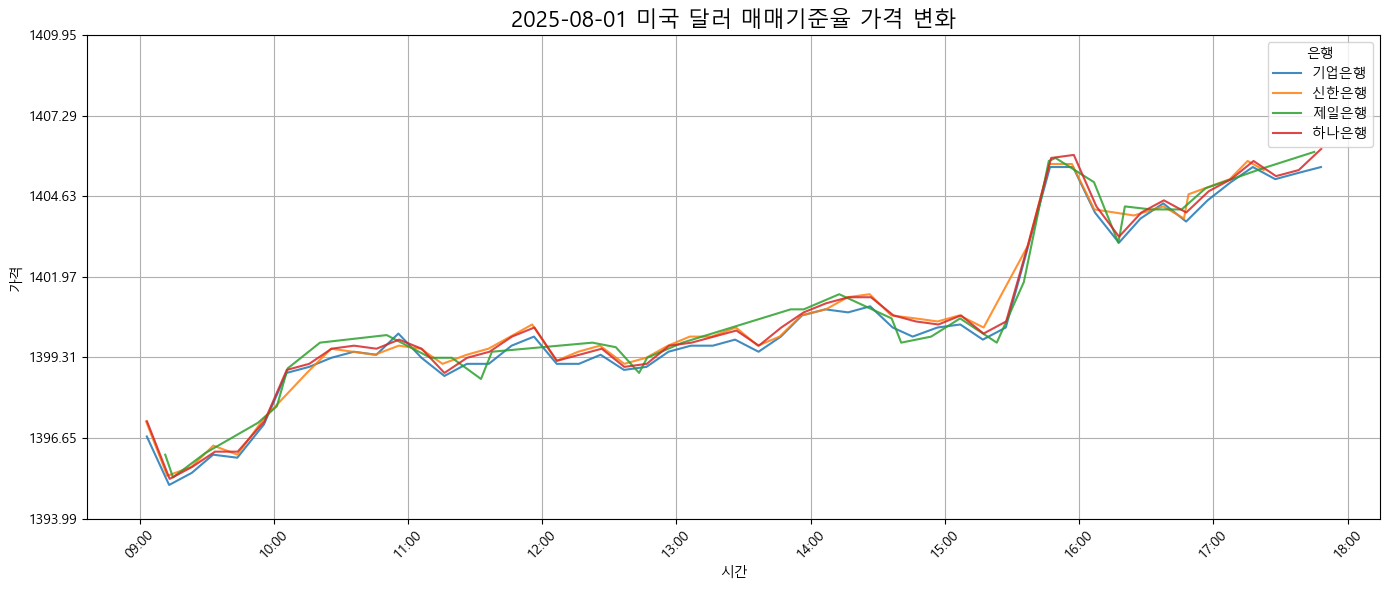

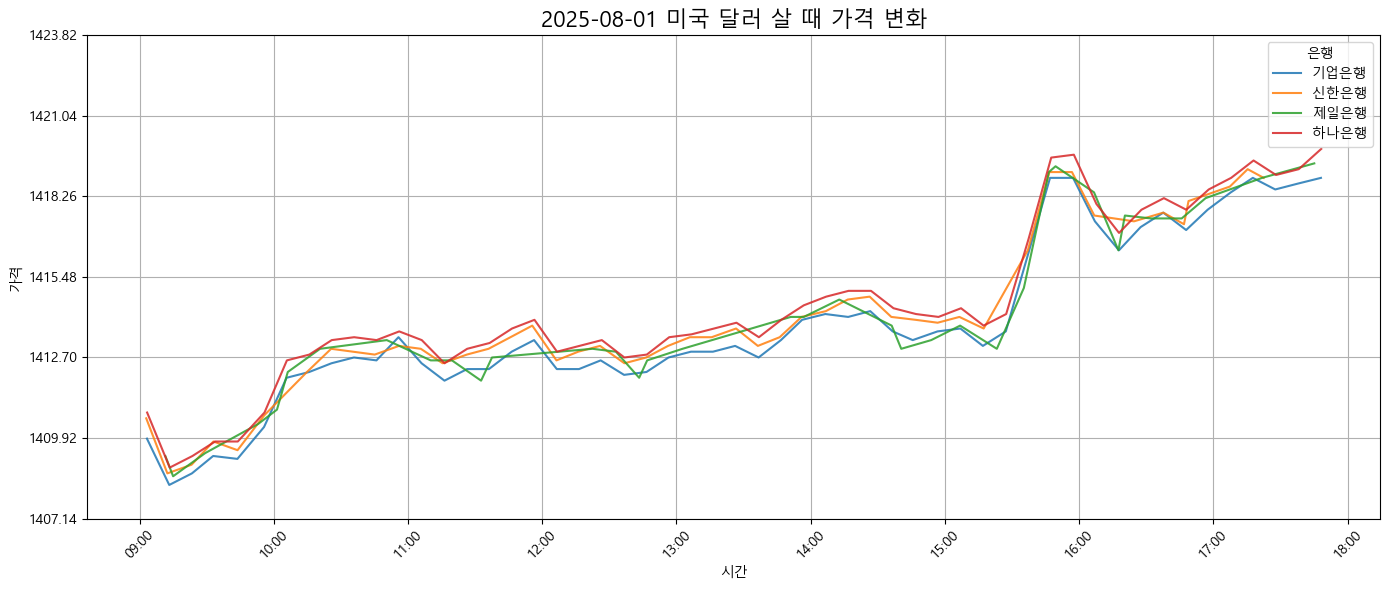

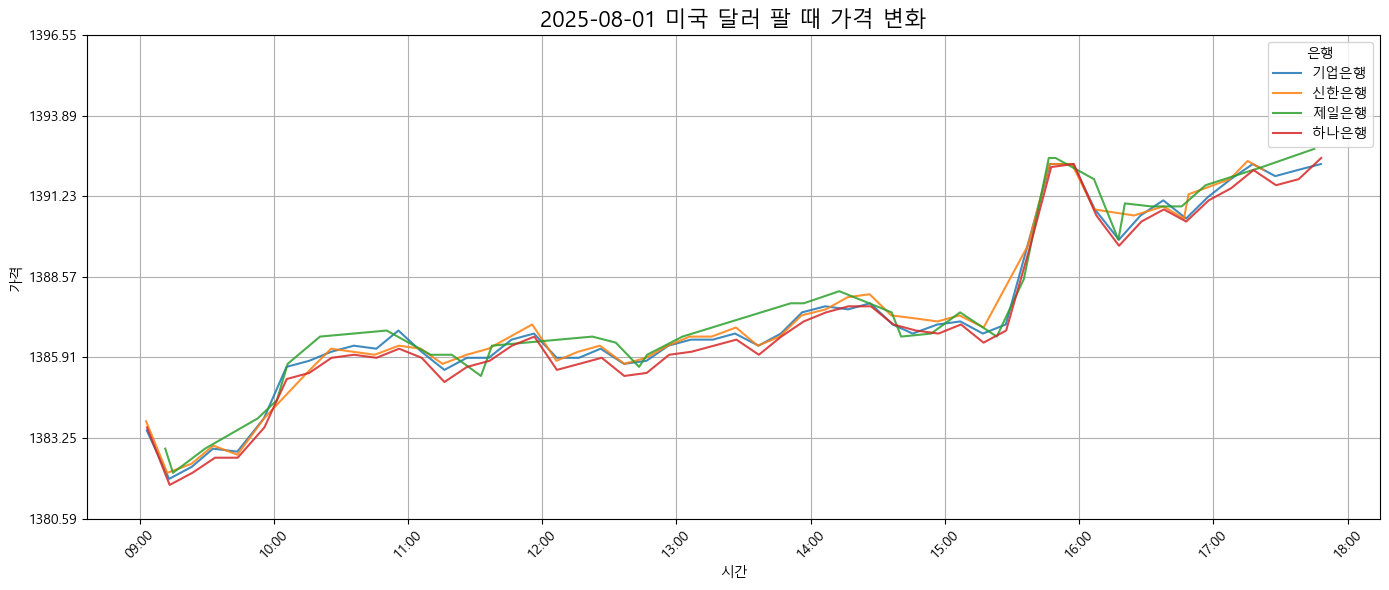

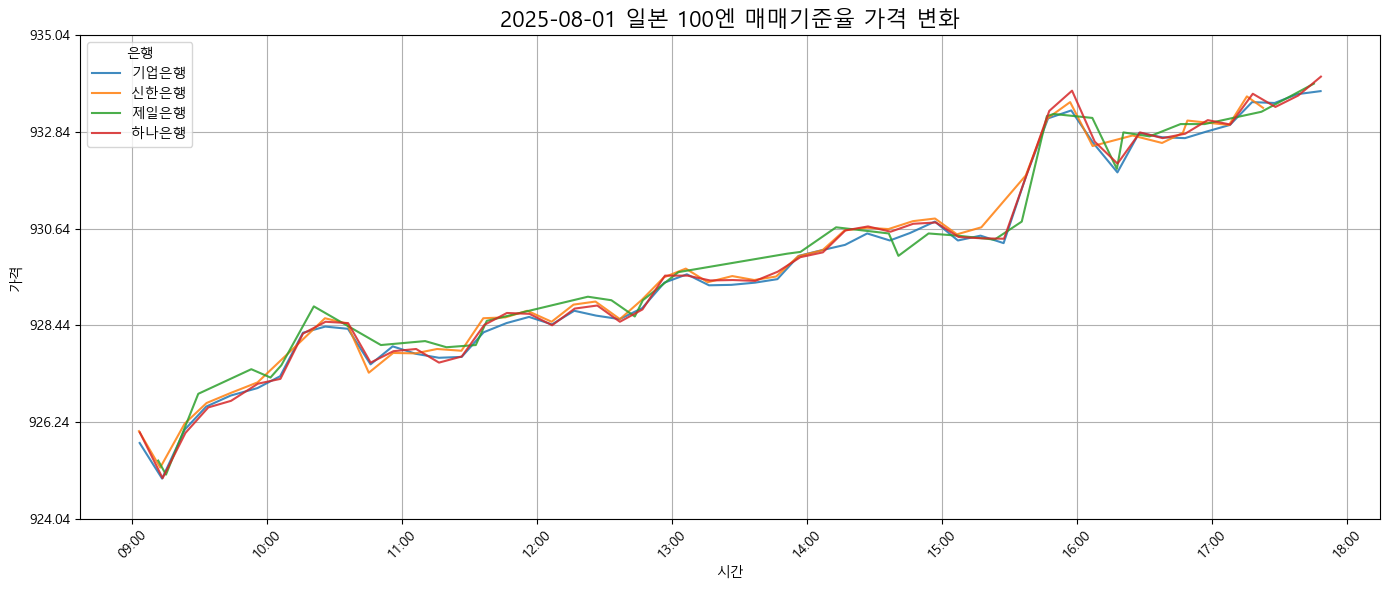

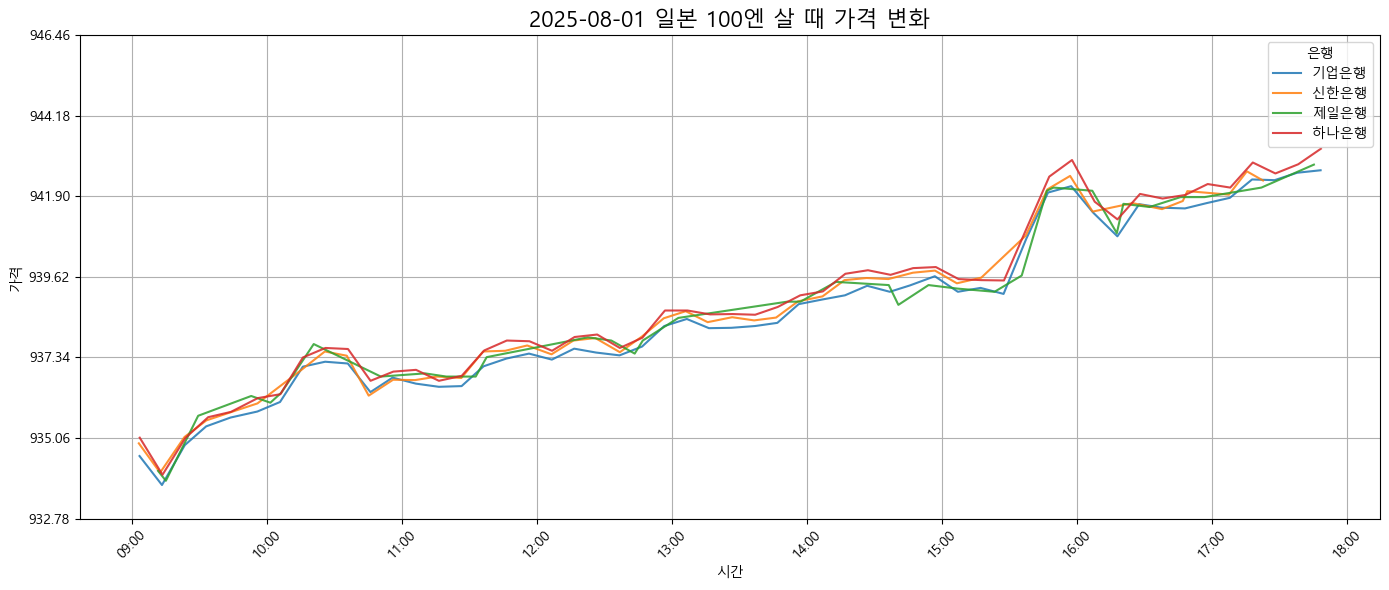

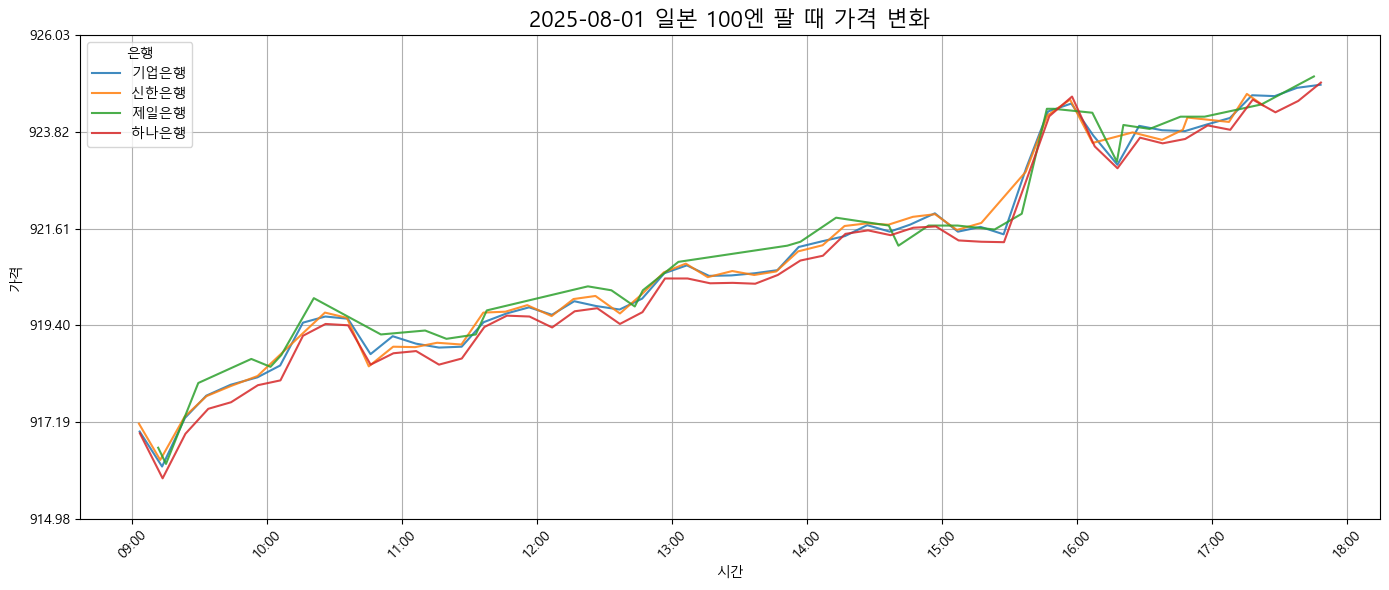

In [15]:
# 쿼리 실행
query = f"""
SELECT 
    er.notice_time,
    er.base_rate,
    er.buy_rate,
    er.sell_rate,
    b.name AS bank_name,
    c.code AS currency_code
FROM exchange_rate er
JOIN bank b ON er.bank_id = b.id
JOIN currency c ON er.currency_id = c.id
WHERE DATE(er.notice_time) = '{TARGET_DATE}'
ORDER BY currency_code, bank_name, er.notice_time;
"""

df = pd.read_sql(query, engine)
df['notice_time'] = pd.to_datetime(df['notice_time'])

# 소수점 범위 생성 함수
def frange(start, stop, step):
    while start <= stop:
        yield round(start, 2)
        start = round(start + step, 10)

# 통화 + rate_type 별 그래프
for currency in CURRENCY_LIST:
    currency_df = df[df['currency_code'] == currency]
    banks = currency_df['bank_name'].unique()
    palette = sns.color_palette('tab10', len(banks))
    bank_color_map = dict(zip(banks, palette))

    for rate_type in RATE_TYPES:
        plt.figure(figsize=(14, 6))

        for bank in banks:
            bank_df = currency_df[currency_df['bank_name'] == bank]
            plt.plot(
                bank_df['notice_time'],
                bank_df[rate_type],
                label=bank,
                color=bank_color_map[bank],
                linewidth=1.5,
                alpha=0.85
            )

        # 제목
        title = f"{TARGET_DATE} {currency_name_map[currency]} {rate_name_map[rate_type]} 가격 변화"
        plt.title(title, fontsize=16)
        plt.xlabel("시간")
        plt.ylabel("가격")

        # ✅ y축 자동 설정
        ymin = currency_df[rate_type].min()
        ymax = currency_df[rate_type].max()
        margin = (ymax - ymin) * 0.1
        ymin = round(ymin - margin, 2)
        ymax = round(ymax + margin, 2)
        step = round((ymax - ymin) / 5, 2)

        plt.ylim(ymin, ymax)
        plt.yticks([y for y in frange(ymin, ymax + step, step)])

        # ✅ x축 시간만
        plt.xticks(rotation=45)
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

        plt.grid(True)
        plt.tight_layout()

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), title="은행")

        plt.show()
        